# <u>Note Méthodologique - Projet 7: "Implémentez un modèle de scoring"<u>

# <u>Sommaire<u>
    
### I. [Présentation générale](#section1)
  - 1. **[Contexte](#section1.1)**
  - 2. **[Les données](#section1.2)**
  - 3. **[Préparation à la modélisation](#section1.3)**
    
### II. [Méthodologie d'entraînement du modèle](#section2)
  - 1. **[Modèles testés](#section2.1)**
  - 2. **[Description de l'entraînement du modèle XGBoost](#section2.2)**

### III. [Optimisation du modèle](#section3)
  - 1. **[Algorithme d'optimisation](#section3.1)**
  - 2. **[Métriques d'évaluation](#section3.2)**
  - 3. **[Seuil de probabilité de défaut de paiement maximisant le profit](#section3.3)**
    
### IV. [Interprétabilité du modèle](#section4)
  - 1. **[Importances globales des variables](#section4.1)**
  - 2. **[Contribution de chaque variable sur une prédiction](#section4.2)**

### V. [Axes d'améliorations, perpectives d'évolution](#section5)

# <u>I. Présentation générale<u><a name="section1"></a>

## <u>I.1. Contexte<u><a name="section1.1"></a>

Dans le cadre du projet n°7 du parcours "Data Scientist" d'OpenClassrooms, nous serons amenés à remplir deux objectifs principaux, à partir des données de Home Credit (https://www.kaggle.com/c/home-credit-default-risk/data). Ces données renseignent les caractéristiques de demandeurs de crédit.

- 1. Implémenter un **modèle de scoring permettant d'évaluer la probabilité de défaut de paiement** d'un crédit donné.
- 2. Développer un **outil interactif permettant à un conseiller financier d'interpréter les prédictions** de ce modèle. L'outil développé est un dashboard disponible à cette adresse: https://dashboard-prevot.herokuapp.com/

Cette note méthodologique synthétise le processus de modélisation choisi pour satisfaire ces objectifs, et définit certaines spécificités des outils utilisés pour interpréter les prédictions.

## <u>I.1. Les données<u><a name="section1.2"></a>

- La base de données de Home Crédit comporte 9 tables reliées entre elles.
- La table principale comporte environ 307 000 demandes de prêt. Chacun de ces prêts est décrit par 121 variables.
- Après nettoyage des données (sélection des variables importantes, élimination des valeurs manquantes, feature engineering), nous obtiendront une jeu de donnés composé d'environ **250 000 crédits décrits par 44 variables**.

## 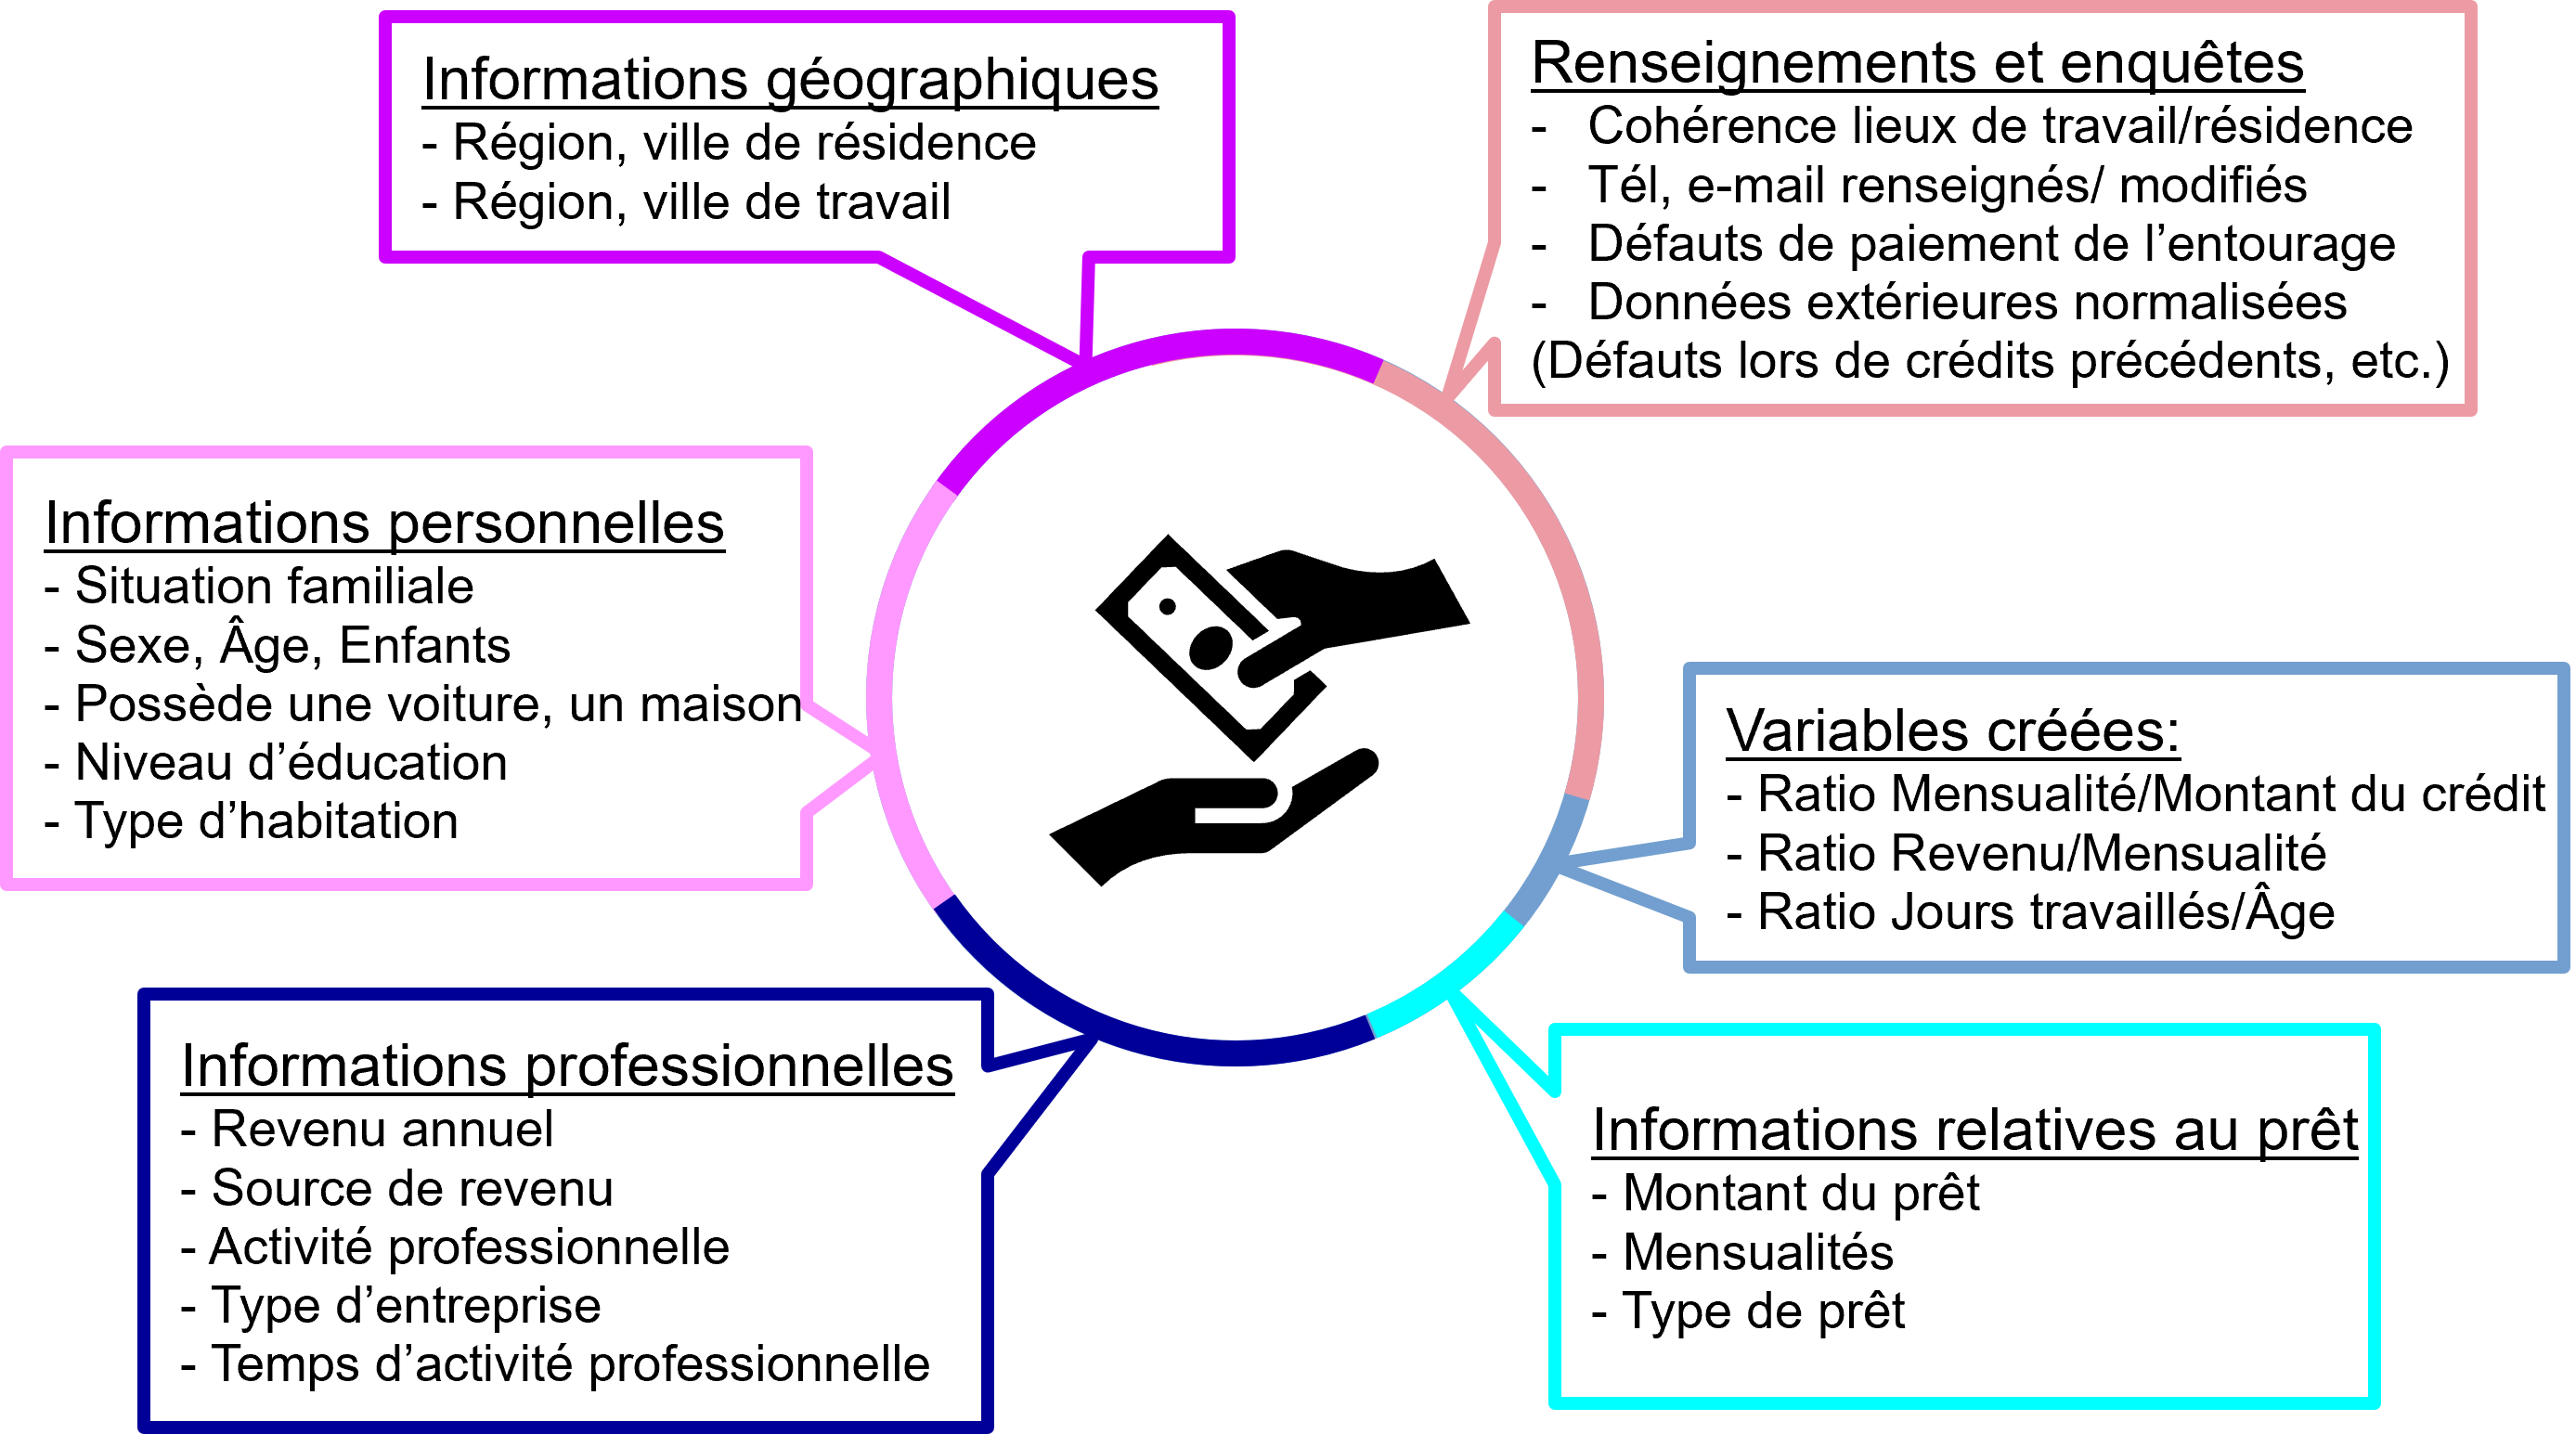

Voici la répartition des clients ayant eu, ou pas, des difficultés à rembourser leur crédit:

- **92% des clients n'ont pas eu de difficulté à rembourser leur prêt**
- **8% des cleints ont eu des difficultés à rembourser leur prêt**

## <u>I.2. Préparation à la modélisation<u><a name="section1.3"></a>

Le rôle du modèle que nous devons implémenter est d'effectuer une **classification binaire: Difficulté de paiement (Classe positive 1), ou pas (Classe négative 0)**. La **classe négative est ici sur-représentée**, ce qui affectera l'entrainement du modèle. Un **modèle naïf qui prédirait toujours qu'un client n'a pas de difficulté de paiement aurait une précision de 92%**. Cependant il n'apporterait rien. Plusieurs approches permettraient de ré-équilibrer les données: 

- Oversampling: RandOverClassif, SMOTE (permettent de créer de nouvelle obsverations de la classe minoritaire)
- Sample weights: augmentation des poids associés aux observations de la classe minoritaire.

Au vu des nombreuses observation disponibles dans le jeu de données, nous choisirons d'effectuer un échantillonage de la classe majoritaire. Cela permettra de réduire le temps d'entrâinement des données par la même occasion:

En prélevant un échantillon qui conserve tous les prêts pour lesquels il y a défaut de paiement (19052 au total), auquel s'ajoute un nombre égal de prêts pour lesquels il n'y a pas de défaut de paiement, on **rééquilibre la répartition des classes**. Cet échantillonage est aléatoire afin d'éviter d'introduire un biais.

# <u>II. Méthodologie d'entraînement du modèle<u><a name="section2"></a>

Plusieurs modèles de machine learning ont été testés. Nous évaluerons leur performance de classification afin de choisir le modèle le plus adapté à notre problématique. 
- La prédicition de chacun de ces modèles est un **score compris en 0 et 1**. Ce score représente la **probabilité de défaut de paiement** du prêt concerné.
- L'évaluation de chaque modèle sera effectuée à partir d'une métrique d'évaluation à définir.
- Le **seuil de refus de paiement** représente la probabilité de défaut de paiement à partir de laquelle nous choisrons de refuser l'accord d'un crédit. Ce seuil sera établi en fonction du profit maximal réalisé par la banque.

Voici un schéma résumant le processus de modélisation:

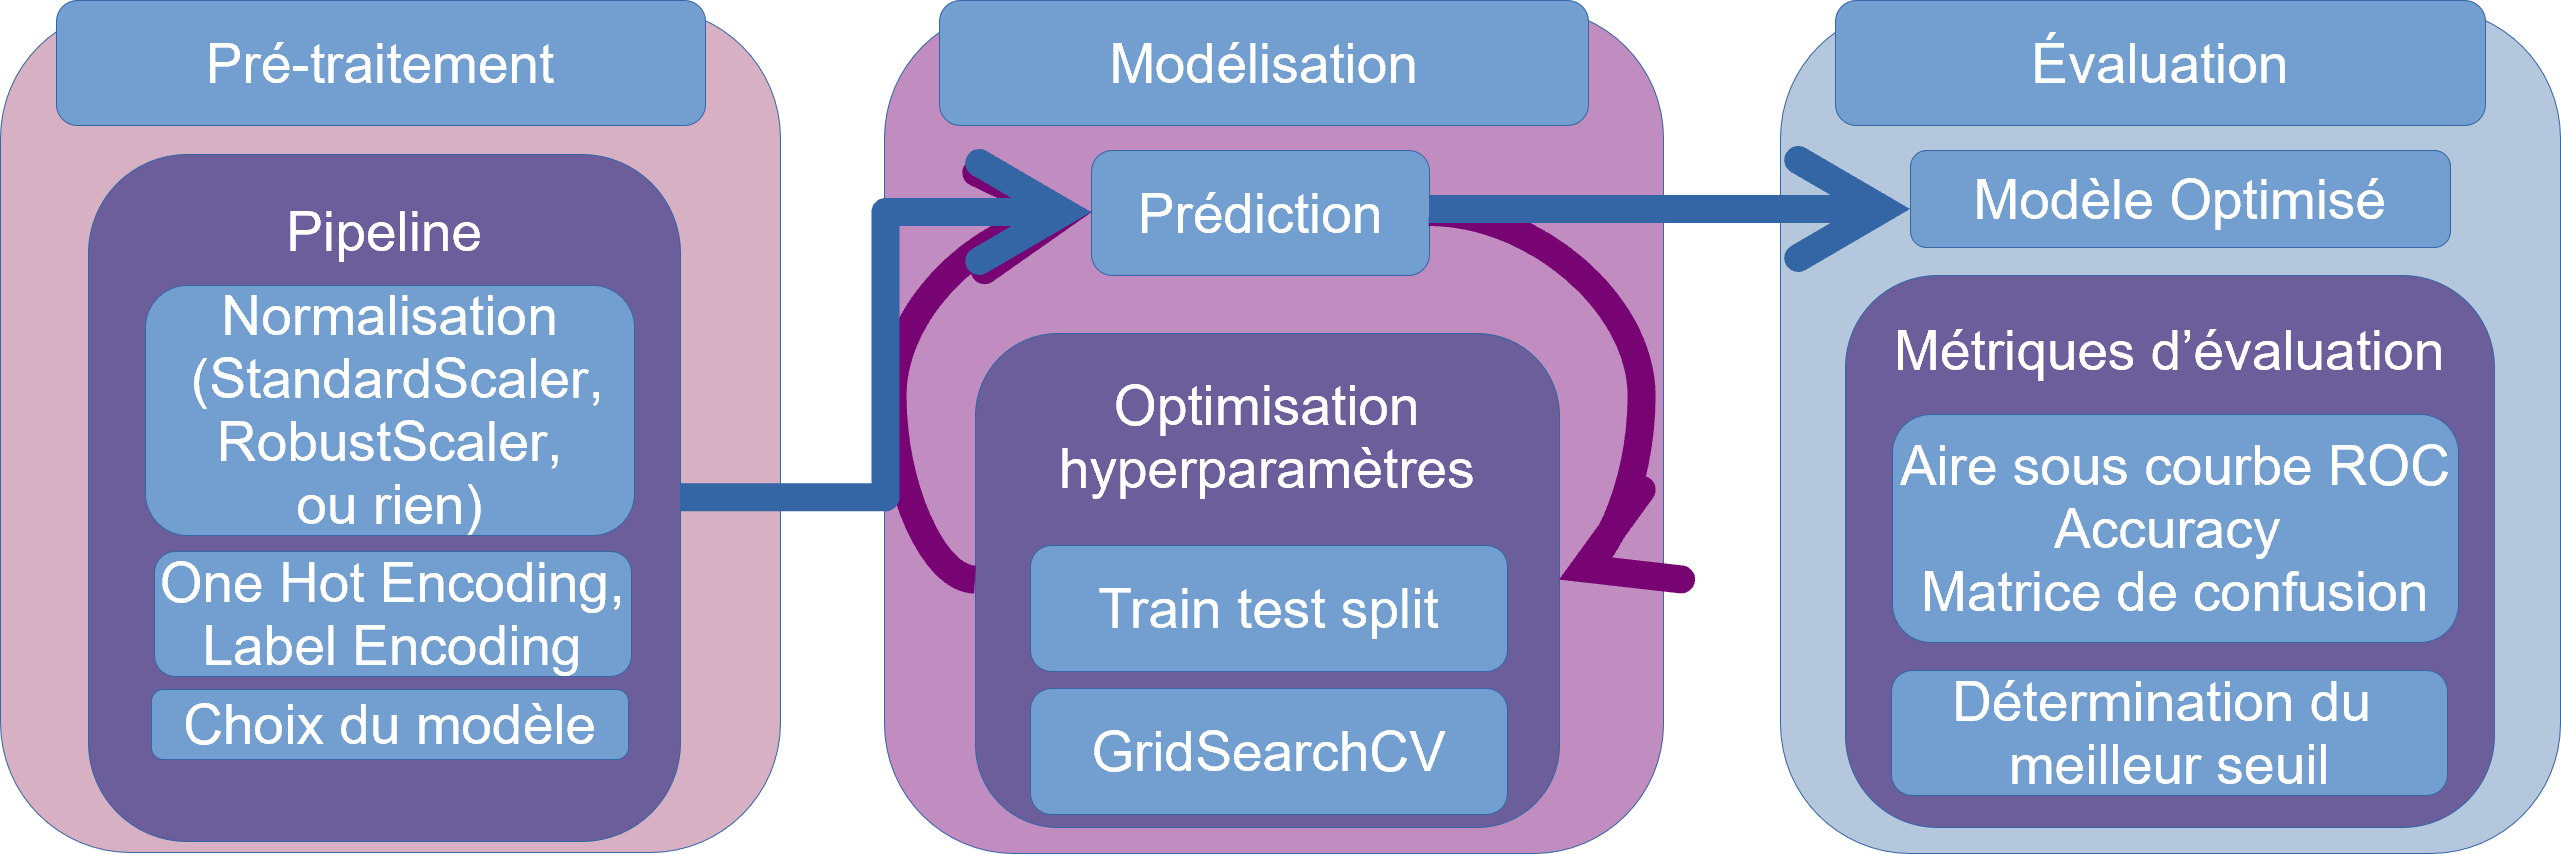

## <u>II.1. Modèles testés<u><a name="section2.1"></a>

Plusieurs modèles ont été optimisés sur un jeu d'entrainement (80%) et évalués un jeu de test(20%), composé chacun d'eniron 50% de crédits remboursés et de 50% de crédits présentant un défaut de paiement. Les modèles testés sont:

- Le classifieur naïf, qui sera notre baseline, prédit toujours que le crédit est remboursé sans difficulté.
- Un modèle de regréssion logistique (seuil de prédiction de base 50%, seuil maximisant le profit 30%).
- Un modèle de classification par forêt aléatoire (seuil de prédiction de base 50%, seuil maximisant le profit 39%).
- Un modèle de Gradient Boosting extrême (seuil de prédiction de base 50%, seuil maximisant le profit 31%).

Nous verrons plus en détail dans la partie III les métriques d'évaluation (AUC...), ainsi que la méthode de détermination du seuil maximisant le profit pour chaque modèle.

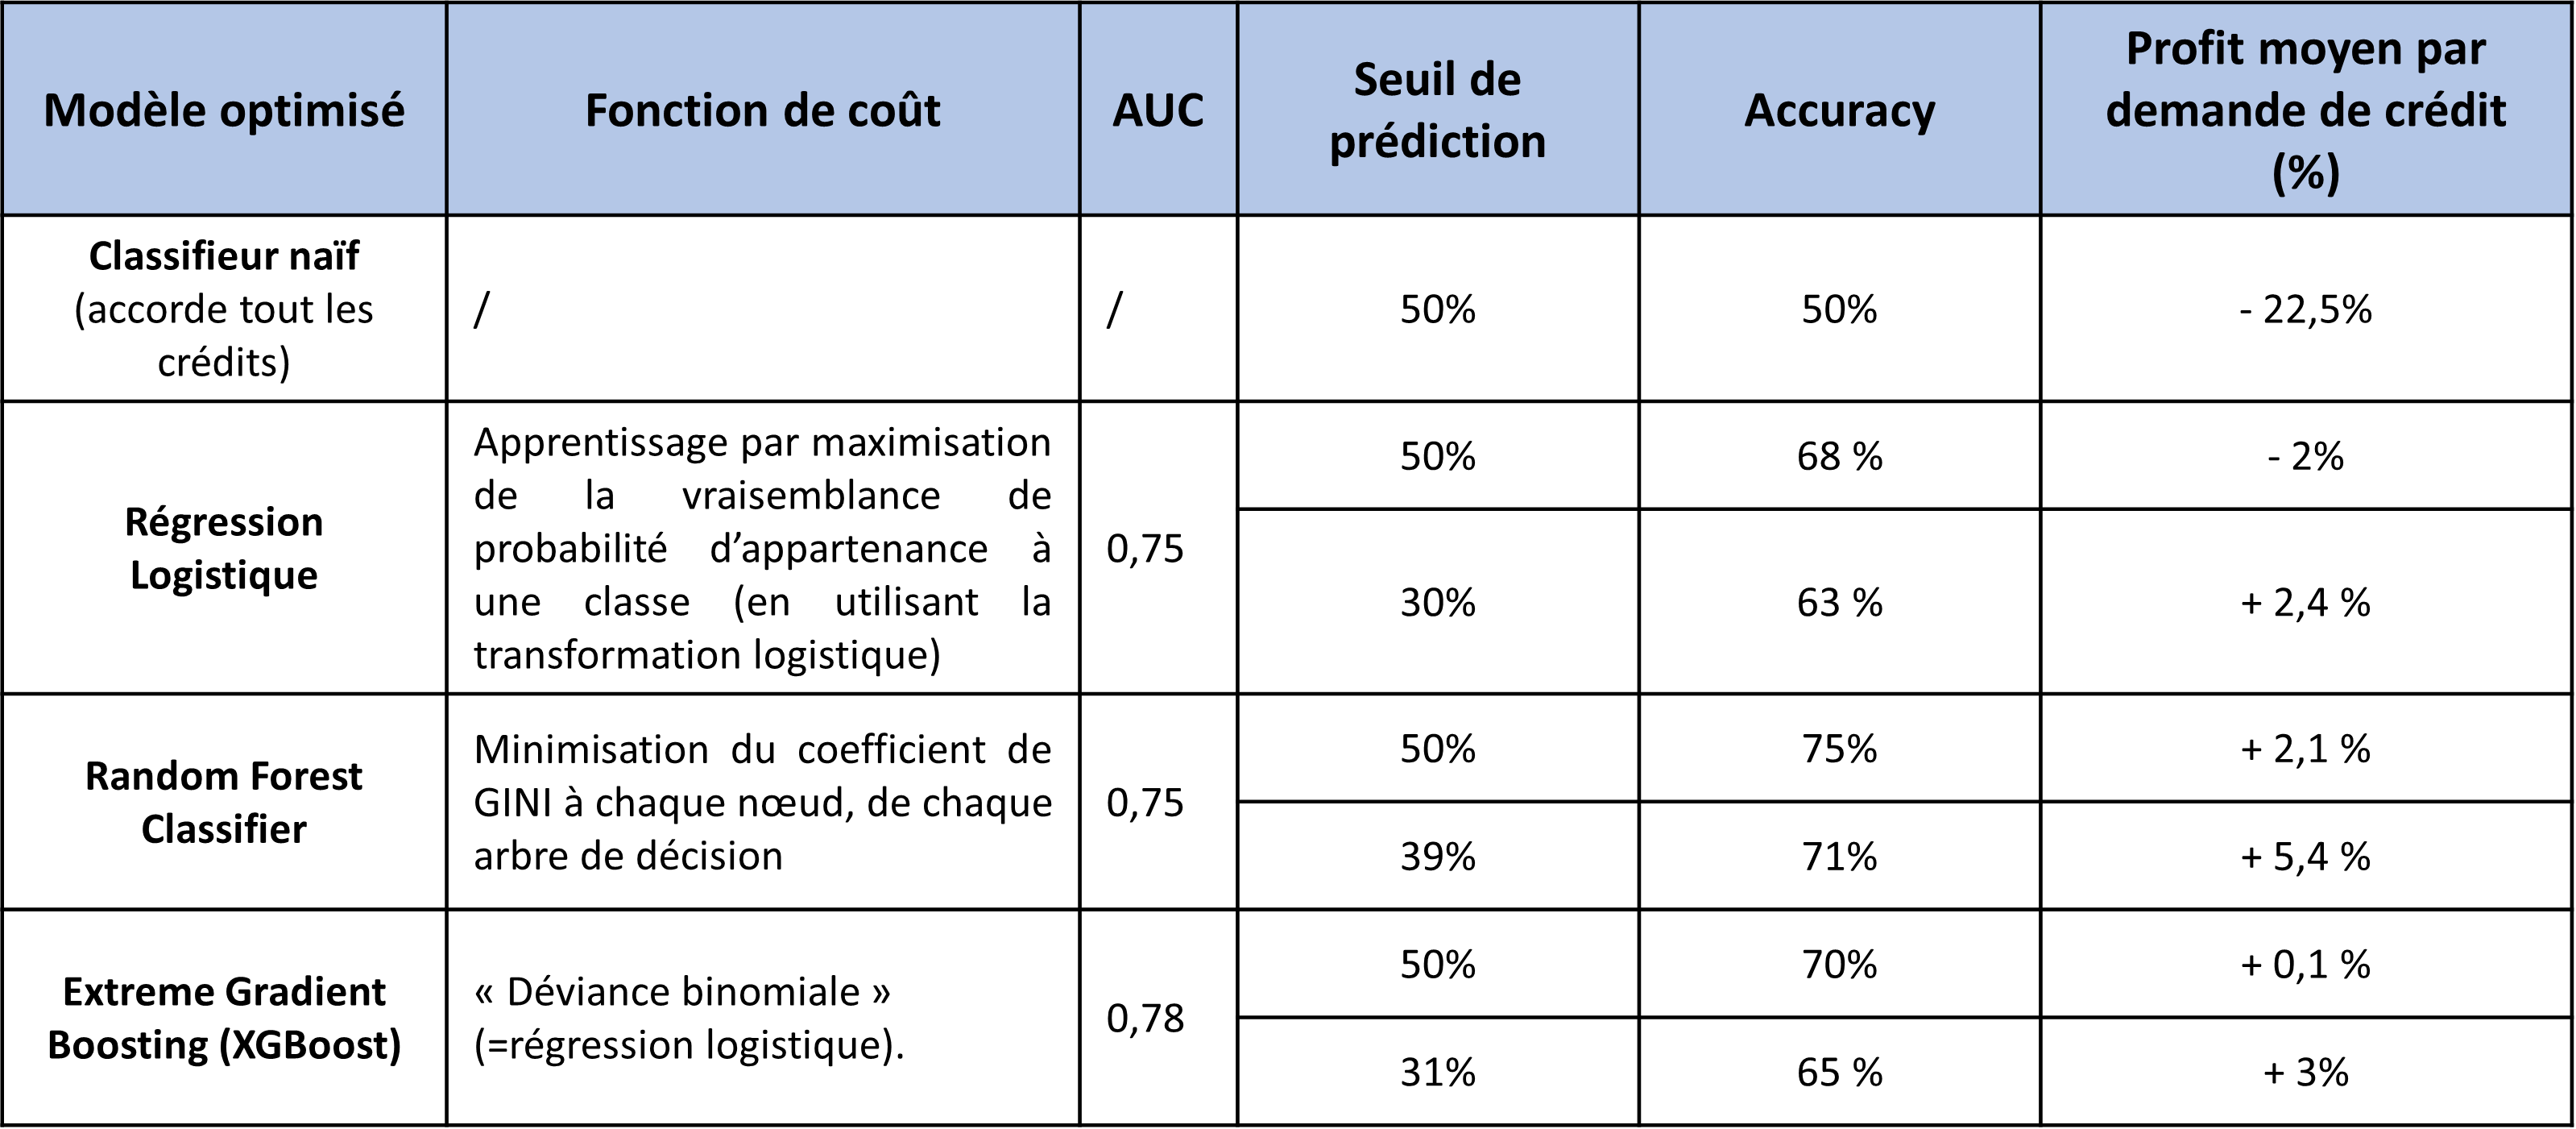

- **Random Forest est le meilleur modèle: 5,4 % de profit moyen** par demande crédit (acceptée ou non).
- Bien que Random Forest soit le modèle dont les prédictions assurent le meilleur profit, **nous choisirons d'utiliser XGBoost**. 
- **XGBoost présente la meilleure AUC**, c'est à dire la meilleure courbe sous la courbe ROC. Si l'on considère sa **performance tous seuils confondus**, ce sera lui qui assurera le meilleur profit. 
- La répartition des demandeurs de crédits n'est pas connue. Nous avons arbitrairement choisi une répartition équilibrée. Cependant **le seuil permettant le meilleur profit varie beaucoup en fonction de cette répartition**. C'est pourquoi dans le doute nous choisirons d'utiliser XGBoost
- XGBoost présent aussi l'avantage de la rapidité comparé à Random Forest. Ce modèle est donc avantageux pour le déploiement et l'utilisation du dashboard présenté précedemment. 

## <u>II.2. Description de l'entraînement du modèle XGBoost<u><a name="section2.2"></a>

Le Gradient Boosting Extreme est un algorithme de classification supervisée, appartenant à la famille des méthode ensemblistes.
Le principe général de cet algorithme est simple: combiner les prédictions de plusieurs arbres de décisions peu profonds.
Le résultat de prédiction sera donc la moeynne des prédictions de tous les arbres de décisions simples.

Par exemple: Le premier apprenant faible prédit une probabilité de défaut de 0.8 et le second prédit 0.4, le troisième prédit 0.9, alors la prédiction finale aura une probabilité de paiement final tellle que:

\begin{equation*}
  Score = (0.8 + 0.4 + 0.9)/3 = 0.7
\end{equation*}

XGBoost est une version optimisée du Gradient Boosting, ce qui la rend bien plus rapide, et souvent plus précise. 
Le Gradient Boosting consiste à améliorer chacun de ces apprenants faibles de façon séquentielle (principe du boosting).
Les lignes principales du fonctionnement de l'entraînement de cet algorithme sont très bien explicitées dans cette vidéo:
https://www.youtube.com/watch?v=jxuNLH5dXCs&t=390s&ab_channel=StatQuestwithJoshStarmer

# <u>III. Optimisation du modèle<u><a name="section3"></a>

Il est possible de modifier certains hyperparamètres du modèle.
Ces paramètres sont:
- Le nombre d'abres de décisions (apprenants faibles) à entraîner: **n_estimators**
- Le coefficient **Learning rate** ou **eta**, correspondant au pas d'apprentissage afin de ralentir l'apprentissage et de réduire l'overfitting. Ces deux paramètres ont été déterminé en trouvant la combianaison qui maximise le score (AUC).

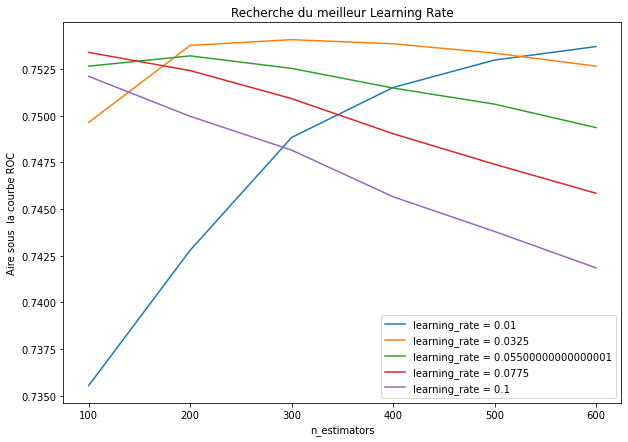

- La profondeur de chacun des arbres de décisions: **max_depth**
- Une coefficient de régularisation de l'indice de similarité issu de chaque branche **gamma**
- ****

## <u>III.1. Algorithme d'optimisation<u><a name="section3.1"></a>

Voici les différentes valeurs possibles des hyperparamètres. 

- 'min_child_weight': [1, 5, 10],
- 'gamma': [0.5, 1, 1.5, 2, 5],  
- 'subsample': [0.6, 0.8, 1.0],
- 'colsample_bytree': [0.6, 0.8, 1.0],
- 'max_depth': [3, 4, 5, 6 , 7 ? 8, 9, 10]

Le but de l'algorithme d'optimisation est de tester différentes combinaisons de ces hyperparamètres, et de trouver celle qui permet de maximiser le score (Ici l'aire sous la courbe ROC - AUC).

Il serait possible de tester toutes les combinaisons, en utilisant un algorithme de type GridSearchCV de scikit-learn, cependant le temps d'exécution d'un tel algorithme serait trop important.

Nous choisirons d'effectuer la recherche des meilleurs hyperparamètres en testant un nombre limité de combinaisons, sélectionnées aléatoirement (en utilisant l'algorithme RandomizedSearchCV de scikit-learn). Afin d'éviter l'over-fitting des données d'entrâinement, nous choisirons d'évaluer les modèles sur un jeu de cross validation de 4 folds.


Le schéma ci-dessous synthétise le processus d'optimisation des hyperparamètres d'XGBoost:

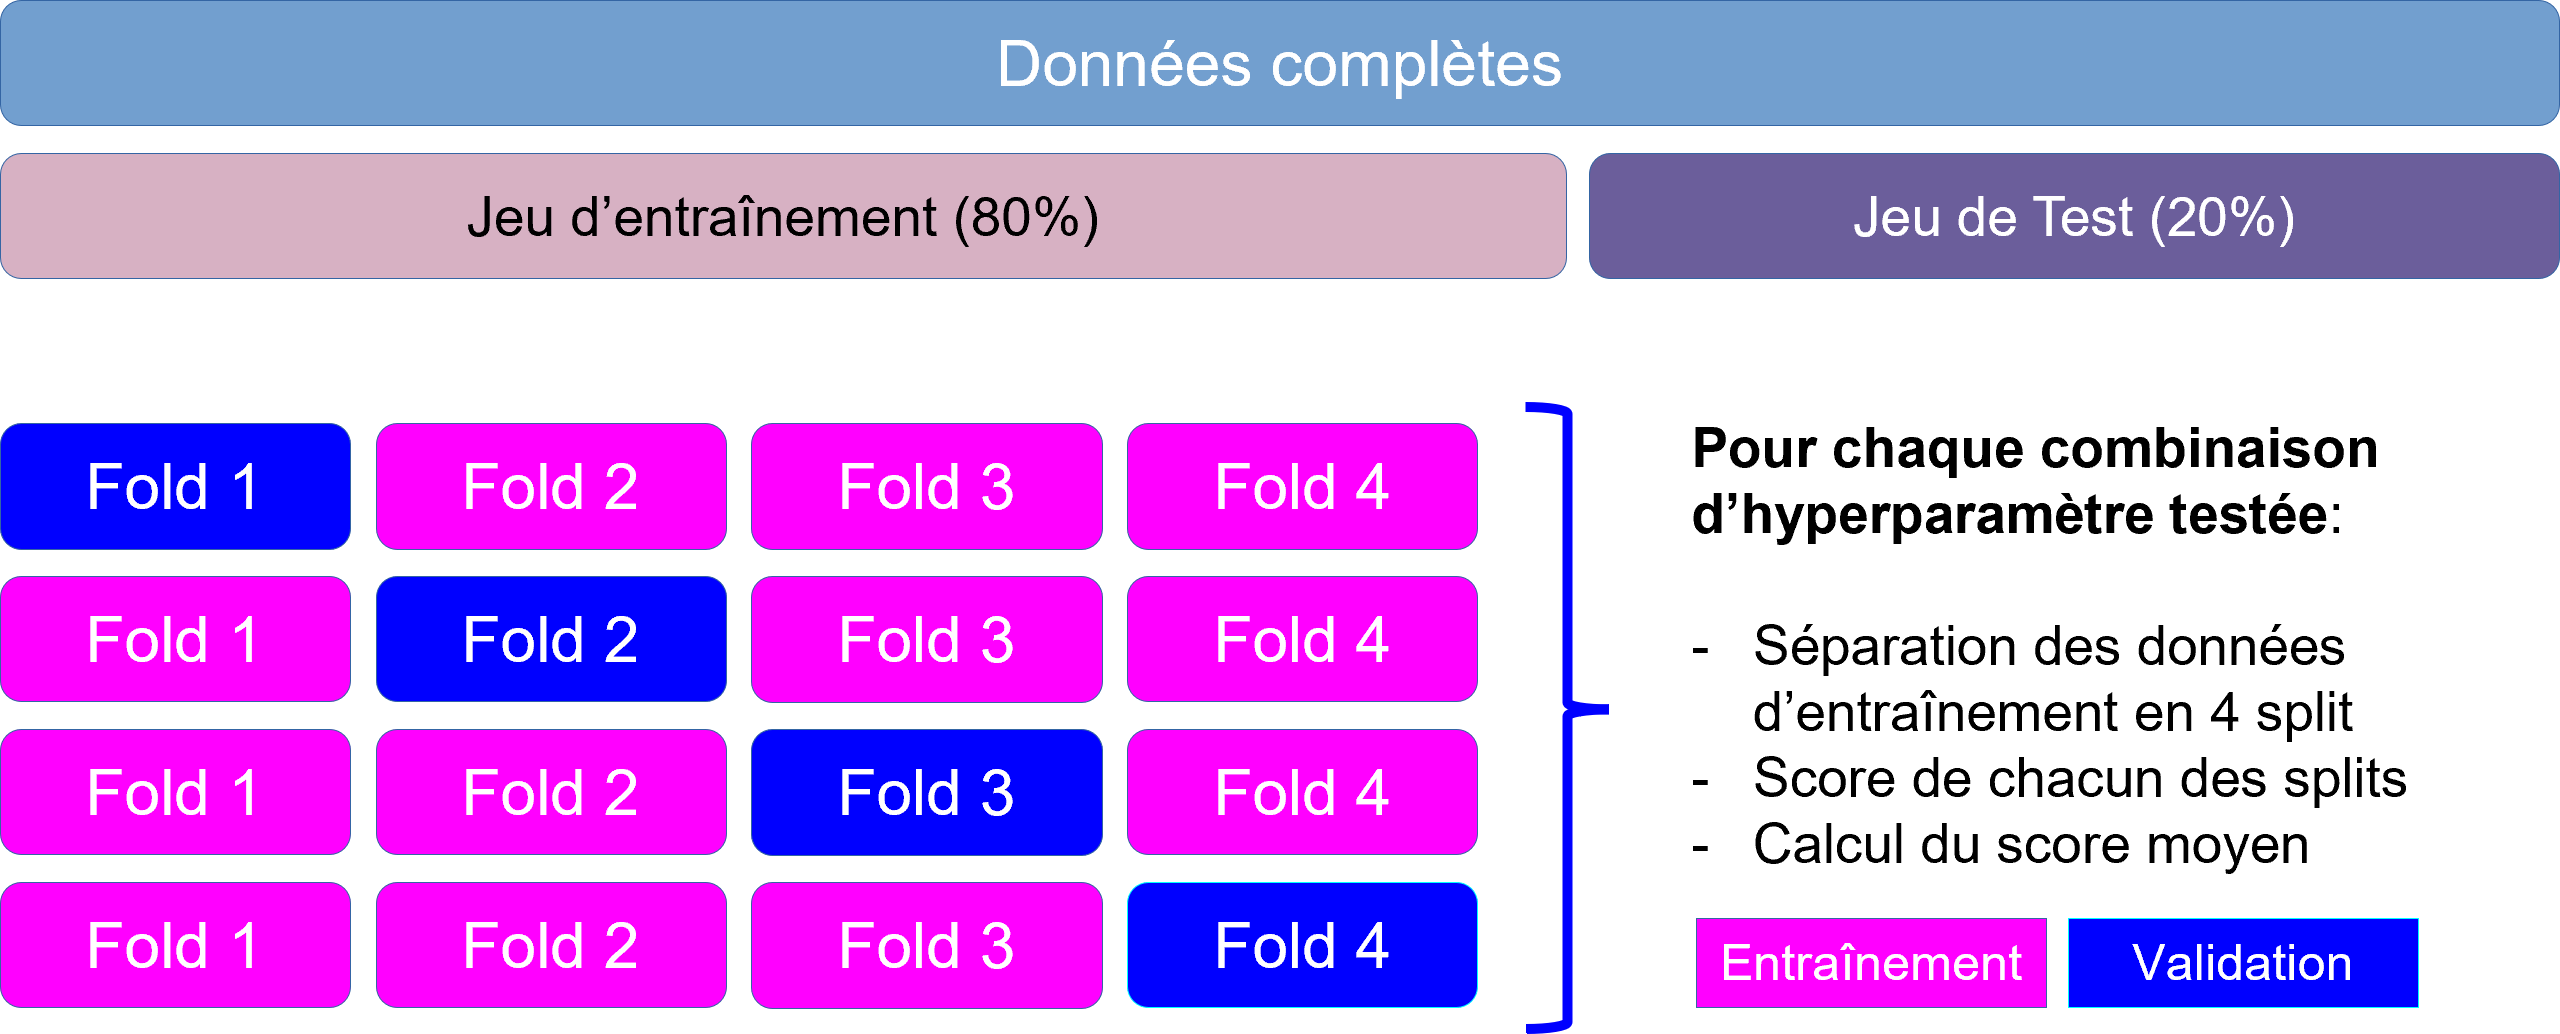

L'algorithme renvoie par la suite la combinason qui aura le meilleur score moyen.
L'évaluation du score de cet algorithme repose sur une métrique: l'aire sous la courbe ROC (à maximiser).

## <u>III.2. Métriques d'évaluation<u><a name="section3.2"></a>

L'aire sous la courbe ROC est établie à partir des probabilités prédites par le modèle.
En faisant évoluer le seuil de prédiction seuil (entre 0 et 1), on place les points au coordonnées (Taux de vrais positifs, taux de vrais négatifs). Après avoir relié les points, on calcule l'aire sous la courbe ainsi formée.

- Lorsqu'on a un classifieur aléatoire, le taux de vrais positifs est égal au taux de faux négatif, peu importe le seuil. L'aire sous la courbeest donc de 0,5.
- Pour un classfieur parfait, le taux de vrais positifs est toujours égal à 1. Ainsi l'aire sous la courbe est égale à 1. 

L'objectif est donc de maximiser cette aire sous la courbe, afin d'aobtenir un bon classifieur.


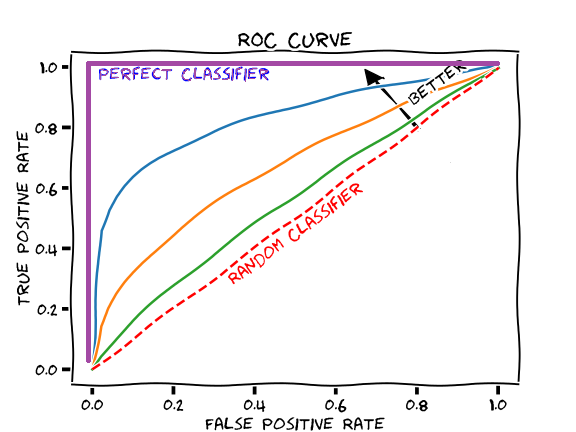

Voici la courbe ROC du modèle XGBoost optimisé

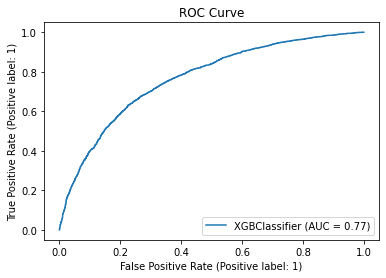

Une autre métrique d'évaluation utilisée sera l'accuracy. Celle-ci permet d'obtenir le taux d'observations du jeu de test correctement classifiées.

Afin d'obtenir d'autres statistiques indiquant la façon dont les observations sont classifiées, nous visualiserons la matrice de confusion de la classification(normalisée ou pas).

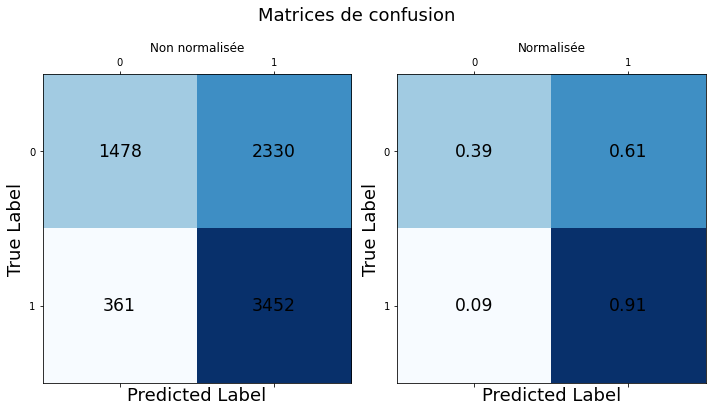

Ici, nous observons que 39% des clients sans difficultés de paiement ont étét correctement classifiés (Vrais négatifs), et que 91% des clients en défaut de paiement ont été correctement classifiés (Vrais positifs).

## <u>III.3. Seuil de probabilité de défaut de paiement maximisant le profit <u><a name="section3.3"></a>

Une première façon d'évaluer le modèle est d'observer sa matrice de confusion, et d'en déduire certains indicateurs comme la précision, le rappel, l'accuracy ...

Cependant, ces statistiques ne prennent pas en compte le coût d'une erreur. Une mauvaise prédiction de défaut de paiement peut potentiellement un impact plus important qu'une mauvaise prédiction de non défaut de paiement, ou inversement. Cala revient au même, par exemple, ne pas détecter un passager criminel au contrôle de sécurité d'un aéroport a des conséquences plus graves que de classer par erreur un passager non menaçant comme dangereux. Par conséquent, ces deux types de prédictions incorrectes doivent être pondérés différemment.

Il sera déterminant de quantifir cette influence et de l'intégrer à notre démarche d'évalution.
Dans notre cas, la performance du modèle peut être caractérisée par le bénéfice attendu. L'objectif de la classification sera de maximiser le bénéfice de la banque.
- Nous attribuerons **un coût négatif (-0.8) aux faux négatifs (FN)** - demandeurs risqués dont le crédit est approuvé. (Un client ayant des difficulté de paiement remboursera en moyenne 20% de son crédit).
- Nous attribuerons **un bénéfice positif (0,35) aux vrais négatifs (TN)** - demandeurs solvables dont le crédit est approuvé. (Un crédit payé rapportera 35% à la banque.)
- Lorsqu'on refuse un crédit à un client en capacité de le rembourse (FP), il y a un manque à gagner mais la banque ne perd pas d'argent. Ainsi on attribuera 0.
- Lorsqu'on aprouve pas de crédit à un client risqué, on ne gagne rien et on ne perde rien. ON attribue 0 à TP.

Dans notre jeu d'entrâinement, nous avons également réparti les clients en défaut de paiement et les clients en capacité de rembourser leur crédits. 

**Profit moyen par demandeur = TN * 0.35 + FN * (-0.8)**

Si l'on prédit que l'on accorde toujours le prêt: TN=50% et FN=50%
Ainsi, le **profit moyen par demandeur = 0.5 * 0.35 + 0.5 * (-0.8) = -0.225**

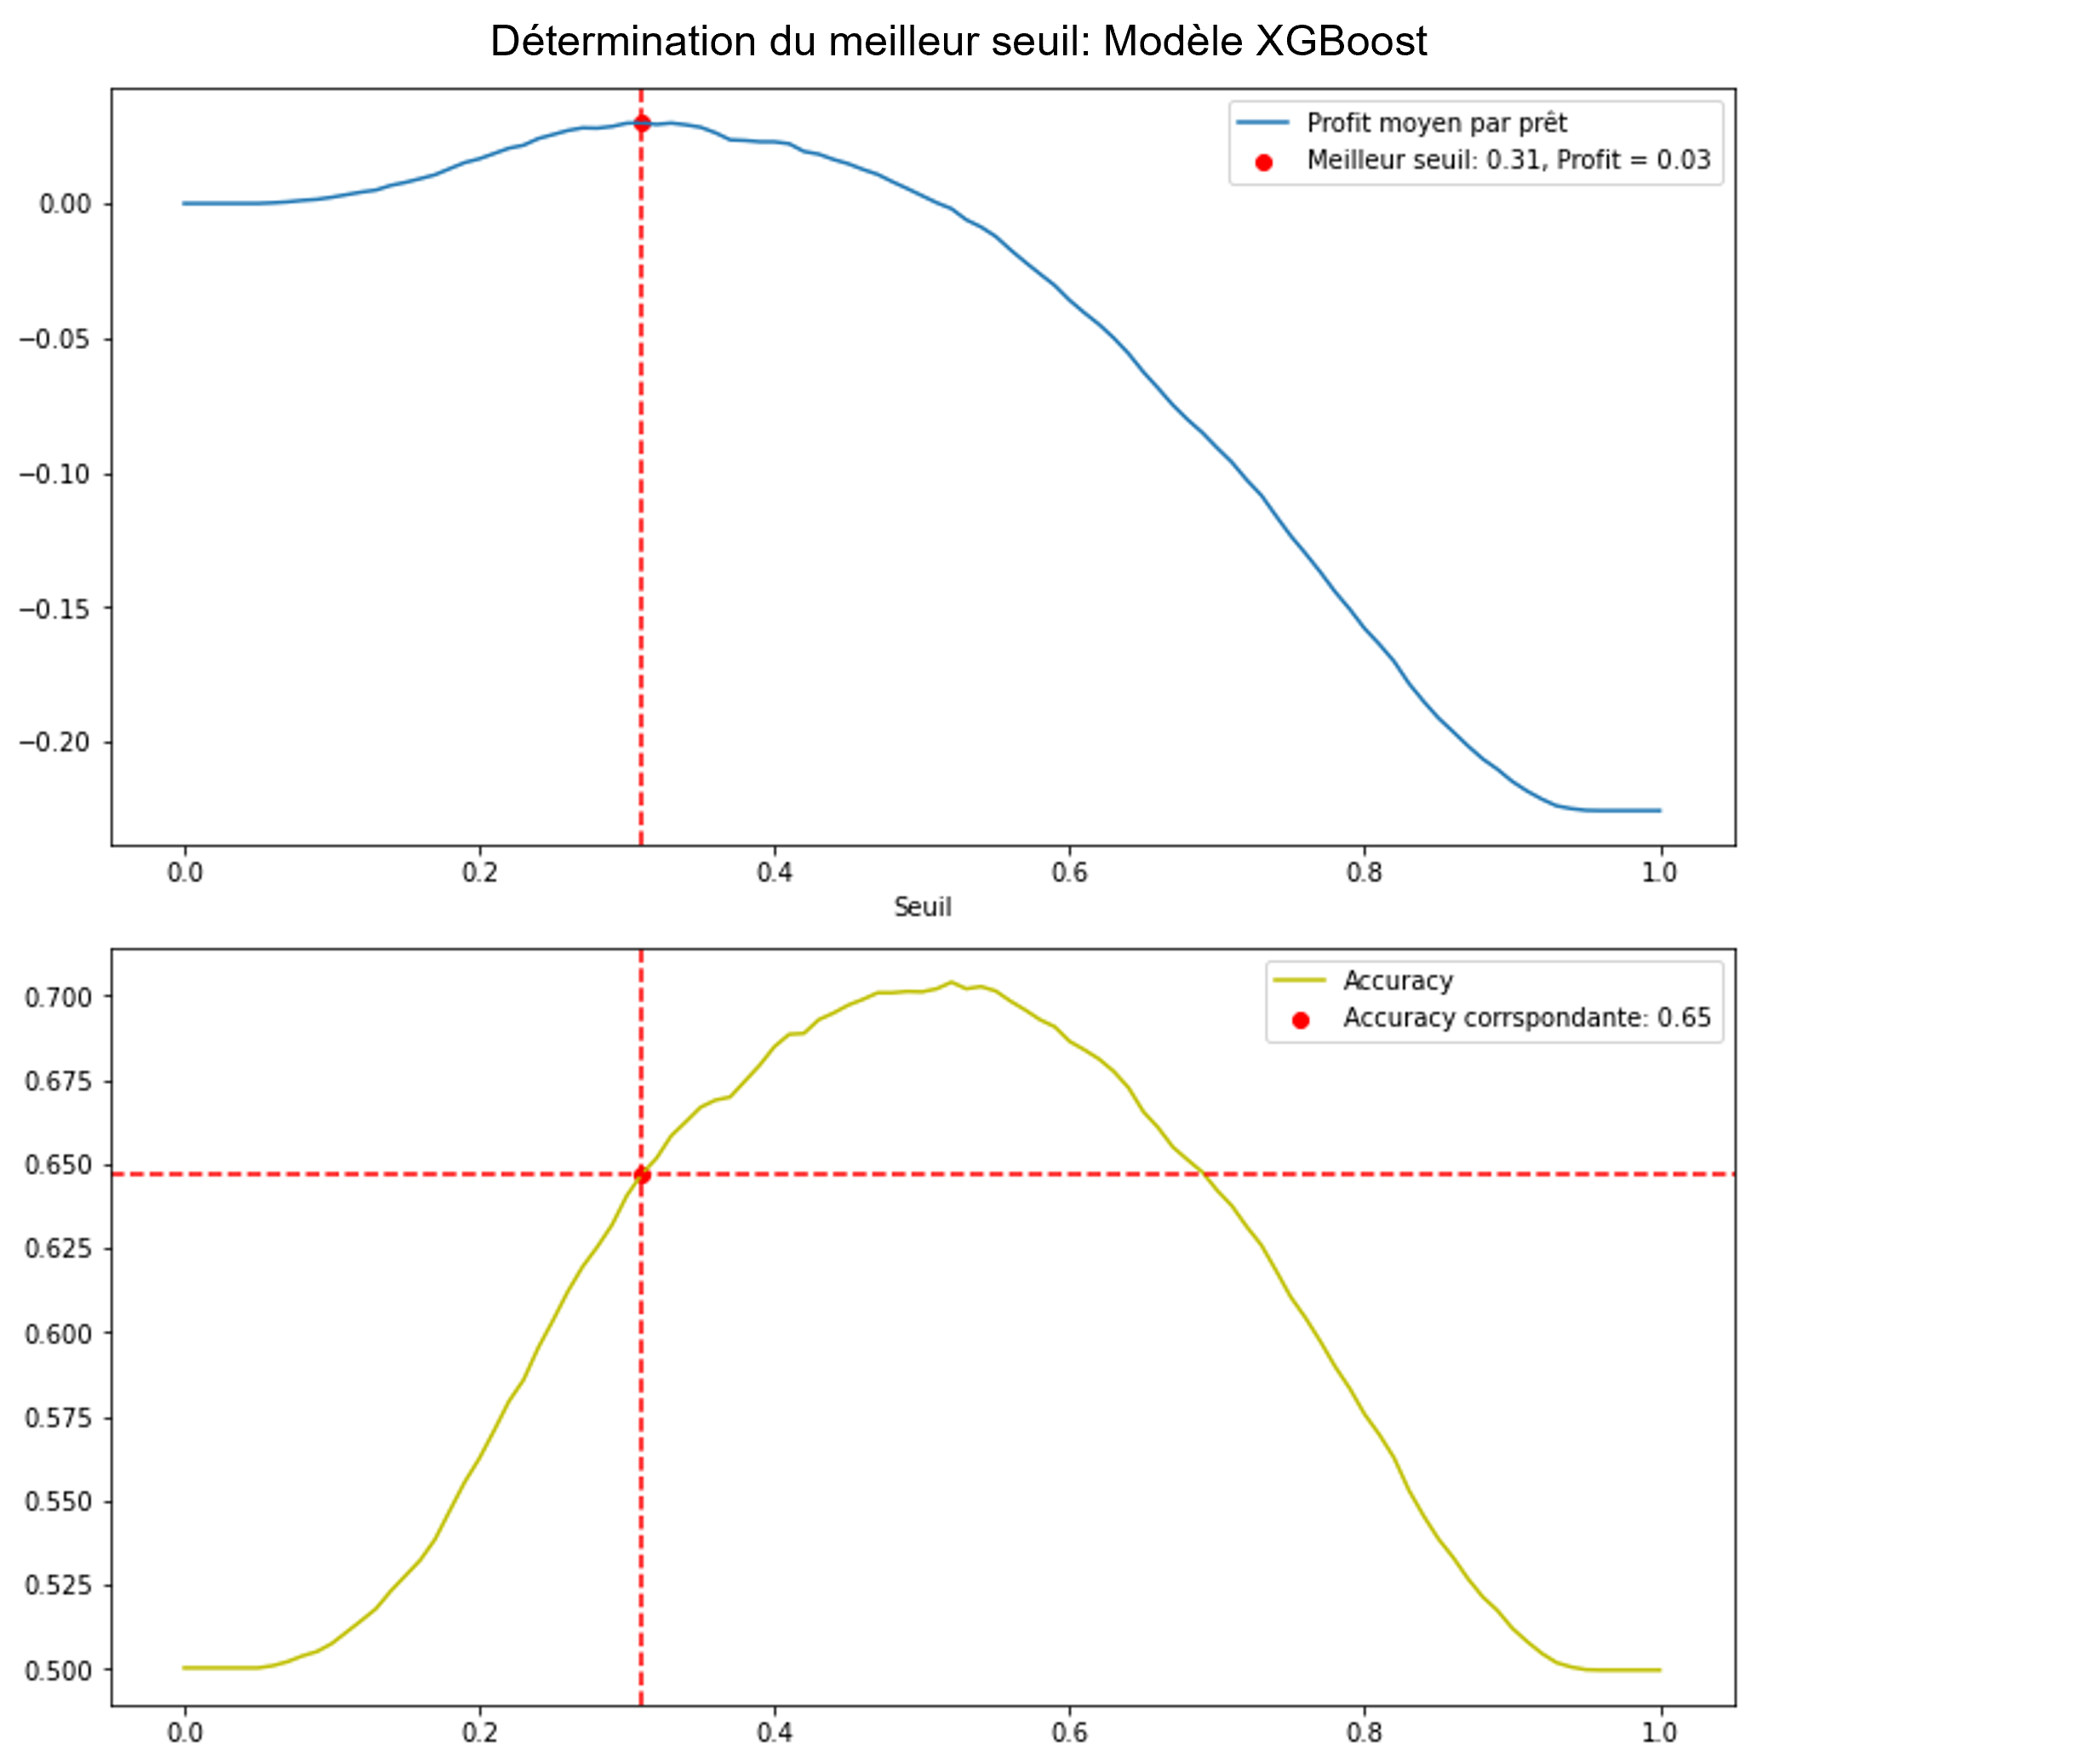

# <u>IV. Interprétabilité du modèle<u><a name="section4"></a>

## <u>IV.1. Importances globales des variables<u><a name="section4.1"></a>

A l'aide de la méthode '.feature_importances_' du modèle XGBoost, il est possible d'avoir une idée de l'influence moyenne de chaque variable.

    L'importance fournit un score qui indique l'utilité de chaque variable dans la construction de chacun des arbres de décision boostés du modèle. Plus une variable est utilisée pour prendre des décisions clés avec les arbres de décision, plus son importance relative est élevée.

Cette importance est calculée explicitement pour chaque variable, ce qui permet de classer les variables et de les comparer entre eulles.

L'importance est calculée (pour un seul arbre) en évaluant à chaque noeud la mesure de performance, pondérée par le nombre d'observations dont le noeud est responsable. La mesure de performance peut être la pureté (indice de Gini) utilisée pour sélectionner les points de séparation ou une autre fonction d'erreur plus spécifique.

La moyenne des importances des caractéristiques est ensuite calculée pour tous les arbres de décision du modèle.

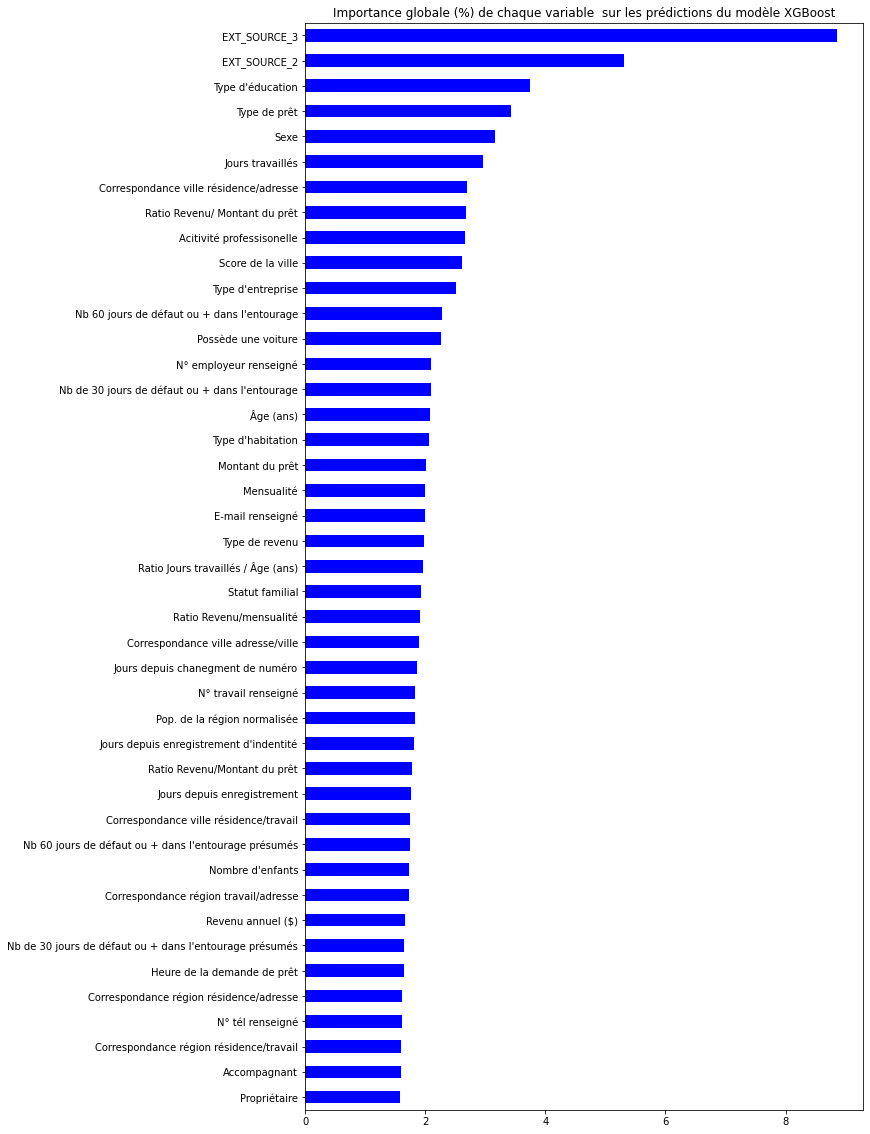

## <u>IV.2. Contribution de chaque variables sur une prédiction<u><a name="section4.2"></a>

La librairie shap permet d'attribuer à n'importe quel modèle des valeurs relatives à la contribution de chaque variable sur les prédictions de celui-ci.

Voici un exemple de "Waterfall plot".
Ce graphique permet de visualiser la contribution individuelle de chaque variable sur la prédiction.
En partant du bas: 
- la prédiction de base est de 50%
- Chaque barre correspond à la shap value standardisée associée à la variable pour cette prédiction. Cela correspond donc à l'influence positive ou négative de la variable (en %).
- Ici une valeur de contibution positive (en rouge) correspond à une augmentation de la probabilité de défaut de paiement.
- Une valeur de contibution négative (en vert) correspond à une diminution de la probabilité de défaut de paiement.

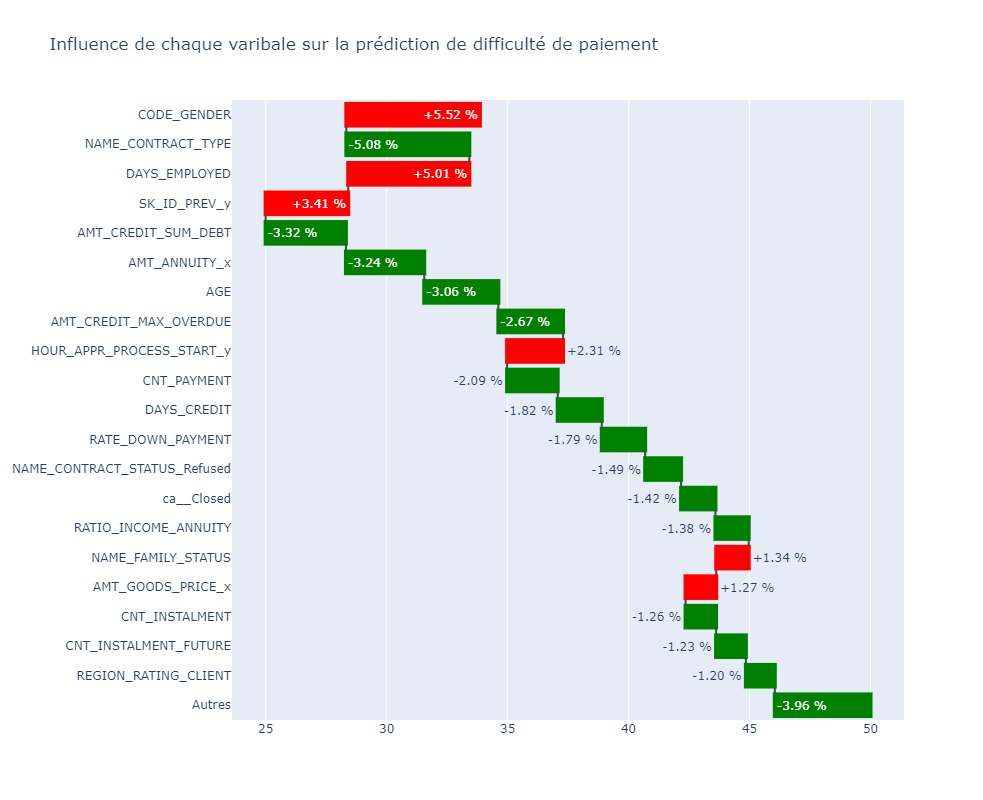

# <u>V. Axes d'améliorations, perpectives d'évolution<u><a name="section5"></a>

- Preprocessing: tester une approche plus complète avec du OneHotEncoding, prise en compte des valeurs manquantes dans le modèle...
- Tester d'autres types de modèles: Réseaux de neurones peu profonds, Support vector classifier, autres méthodes ensemblistes.
- Optimisations d'hyperparamètres plus poussées: utilisation d'hyperopt...
- Interprétabilité: utilisation d'autres outils, LIME explainer...